<a href="https://colab.research.google.com/github/rohansiddeshwara-stride/table_extractor/blob/main/TableExtraction_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyMuPDF=='1.22.5'
!pip install pytesseract
!pip install transformers
!pip install timm
!pip install easyocr
!pip install pdfminer
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 18.6 MB/s eta 0:00:00


In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import cv2
import numpy as np
import csv
import os
from google.colab.patches import cv2_imshow
import pandas as pd

class DetectTable():
  def __init__(self):
    self.processor = DetrImageProcessor.from_pretrained("TahaDouaji/detr-doc-table-detection")
    self.model = DetrForObjectDetection.from_pretrained("TahaDouaji/detr-doc-table-detection")


  def extract_table_bbox(self,image_path):
    tables=[]
    image = Image.open(image_path)
    self.inputs = self.processor(images=np.array(image), return_tensors="pt")
    self.outputs = self.model(**self.inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    self.target_sizes = torch.tensor([image.size[::-1]])
    self.results = self.processor.post_process_object_detection(self.outputs, target_sizes=self.target_sizes, threshold=0.9)[0]

    # Convert PIL image to OpenCV format
    image_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    for score, label, box in zip(self.results["scores"], self.results["labels"], self.results["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      class_label = self.model.config.id2label[label.item()]



      if round(score.item(), 3) > 0.95:
        # Draw rectangle around the detected object
        x_min, y_min, x_max, y_max = map(int, box)
        print(x_min, y_min, x_max, y_max )
        if x_min-10 < 0:
          table= [(x_min), (y_min-10), (x_max+20), (y_max+20)]
        elif y_min-10 < 0:
          table= [(x_min-10), (y_min), (x_max+20), (y_max+20)]
        else:
          table= [(x_min-10), (y_min-10), (x_max+20), (y_max+20)]
        # cv2.rectangle(image_cv2, (x_min-10, y_min-10), (x_max+20, y_max+20), (0, 0, 0), 2)
        tables.append(table)
        # cv2_imshow(image_cv2)
        # print(f"Detected {class_label} with confidence {round(score.item(), 3)} at location {box}")

    return tables, image_cv2

  def extract_bounding_box(self,bbox,image):
      # cv2_imshow(image)
      x1, y1, x2, y2 = bbox
      height=abs(y2-y1)
      width=abs(x2-x1)
      extracted_image = image[y1:y1+height, x1:x1+width]
      return extracted_image

  def execute(self,image_path,folder_name,page):

    if not os.path.exists(folder_name):
      os.mkdir(folder_name)

    tables,_  = self.extract_table_bbox(image_path)
    # print(tables)

    image=cv2.imread(image_path)
    for i,j in enumerate(tables):
      table_img=self.extract_bounding_box(j,image)
      # cv2_imshow(table_img)
      cv2.imwrite(os.path.join(folder_name,f"table{i}_in_page{page}.png"),table_img)

    return tables


In [ ]:


class GenerateTable():
  def __init__(self,table_bbox,page_no,document):
    self.doc = fitz.open(document)
    self.page = self.doc.load_page(page_no)
    self.text_instances = self.page.get_text("words")

    self.table_rect=table_bbox
    self.bbox=table_bbox
    self.selected_text=[]

  def execute(self,page_no,table_no):
    self.extract_words()
    self.bounding_boxes = self.combine_words_along_x(distance_threshold=3)
    if len(self.bounding_boxes)< 1:self.bounding_boxes=[[0,0,1,1," "]]
    self.mean_height =self.get_mean_height_of_bounding_boxes()
    self.mean_width=self.get_mean_width_of_bounding_boxes()


    self.bounding_boxes = self.sort_bounding_boxes_by_y_coordinate(self.bounding_boxes)
    # print(bounding_boxes)
    self.rows=[]
    self.rows = self.club_all_bounding_boxes_by_similar_y_coordinates_into_rows(self.mean_height,self.bounding_boxes,self.rows)
    self.rows = self.sort_all_rows_by_x_coordinate(self.rows)
    # print(rows)
    # print(len(rows))

    self.bounding_boxes=self.sort_bounding_boxes_by_x_coordinate(self.bounding_boxes)
    # print(bounding_boxes)
    self.columns =[]
    self.columns = self.club_all_bounding_boxes_by_similar_x_coordinates_into_columns(self.mean_width,self.bounding_boxes,self.columns)
    self.columns = self.sort_all_columns_by_y_coordinate(self.columns)
    # print(columns)
    # print(len(columns))


    self.row_table = self.crop_each_bounding_box_and_ocr_rows(self.rows)
    # print(row_table)

    self.column_table = self.crop_each_bounding_box_and_ocr_cols(self.columns)
    # print(column_table)

    self.table = self.create_final_table(self.row_table,self.column_table)

    self.generate_csv_file(self.table,page_no,table_no)

    table_extracted=self.generate_json(self.table,page_no,self.bbox)
    return table_extracted


  def intersects_rect(self,table_rect,bbox):
    if table_rect[0]<=bbox[0] and table_rect[1]<=bbox[1] and table_rect[2]>=bbox[2] and table_rect[3]>=bbox[3]:
      return True
    else:
      return False

  def extract_words(self):
    for inst in self.text_instances:
      bbox = inst[0:4]
      if self.intersects_rect(self.table_rect,bbox):
          self.selected_text.append(inst[0:5])

  def combine_words_along_x(self, distance_threshold=10):
    bbox_list = self.selected_text
    combined_words = []

    i = 0
    while i < len(bbox_list):
        curr_bbox = bbox_list[i]
        combined_text = curr_bbox[4]
        x1, y1, x2, y2 = curr_bbox[:4]

        j = i + 1
        while j < len(bbox_list):
            next_bbox = bbox_list[j]
            next_x1, next_y1, _, _ = next_bbox[:4]

            if next_x1 - x2 <= distance_threshold and next_y1 - y2 <= 0.2:
                combined_text += " " + next_bbox[4]
                x2 = next_bbox[2]
                j += 1
            else:
                break

        combined_words.append((x1, y1, x2, y2, combined_text))
        i = j

    return combined_words



  def get_mean_height_of_bounding_boxes(self):
    heights = []
    for bounding_box in self.bounding_boxes:
        # print(bounding_box)
        x1, y1,x2 , y2,_ = bounding_box
        heights.append(abs(y2-y1))
    return np.mean(heights)

  def get_mean_width_of_bounding_boxes(self):
    widths = []
    for bounding_box in self.bounding_boxes:
        x1, y1, x2, y2 ,_ = bounding_box
        widths.append(abs(x2-x1))
    return np.mean(widths)

  def sort_bounding_boxes_by_y_coordinate(self,bounding_boxes):
      self.bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])
      # print(bounding_boxes)
      return self.bounding_boxes
  def sort_bounding_boxes_by_x_coordinate(self,bounding_boxes):
      self.bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])
      # print(bounding_boxes)
      return self.bounding_boxes

  def club_all_bounding_boxes_by_similar_y_coordinates_into_rows(self,mean_height,bounding_boxes,rows):
      half_of_mean_height = mean_height/3
      current_row = [ self.bounding_boxes[0] ]
      for bounding_box in bounding_boxes[1:]:
          current_bounding_box_y = bounding_box[1]
          previous_bounding_box_y = current_row[-1][1]
          distance_between_bounding_boxes = abs(current_bounding_box_y - previous_bounding_box_y)
          if distance_between_bounding_boxes <= half_of_mean_height:
              current_row.append(bounding_box)
          else:
              rows.append(current_row)
              current_row = [ bounding_box ]
      rows.append(current_row)
      # print(rows)
      return rows

  def club_all_bounding_boxes_by_similar_x_coordinates_into_columns(self,mean_width,bounding_boxes,columns):
    half_of_mean_width = mean_width / 3.2
    current_column = [self.bounding_boxes[0]]
    for bounding_box in bounding_boxes[1:]:
        current_bounding_box_x = bounding_box[0]
        previous_bounding_box_x = current_column[-1][0]
        distance_between_bounding_boxes = abs(current_bounding_box_x - previous_bounding_box_x)
        if distance_between_bounding_boxes <= half_of_mean_width:
            current_column.append(bounding_box)
        else:
            columns.append(current_column)
            current_column = [bounding_box]
    columns.append(current_column)
    # print(columns)
    return columns

  def sort_all_rows_by_x_coordinate(self,rows):
      for row in rows:
          row.sort(key=lambda x: x[0])
      return rows


  def sort_all_columns_by_y_coordinate(self,columns):
      for column in columns:
          column.sort(key=lambda x: x[1])
      return columns


  def crop_each_bounding_box_and_ocr_rows(self,rows):
    row_table=[]
    current_row = []
    for row in rows:
        for bounding_box in row:
            x1, y1, x2, y2 ,text = bounding_box
            if abs(x2-x1)>7 :
              current_row.append("\""+bounding_box[-1]+"\"")

        row_table.append(current_row)
        current_row = []
    # print(row_table)
    return row_table

  def crop_each_bounding_box_and_ocr_cols(self,columns):
      column_table=[]
      current_row = []
      image_number = 0
      for row in columns:
          for bounding_box in row:
              x1, y1, x2, y2 ,text = bounding_box
              if abs(x2-x1)>7 :
                current_row.append("\""+bounding_box[-1]+"\"")
          column_table.append(current_row)
          current_row = []
      # print(column_table)
      return column_table

  def find_element_position(self,matrix, target_element):
    for row_index, row in enumerate(matrix):
        for col_index, element in enumerate(row):
            if element == target_element:
                matrix[row_index][col_index]=" "
                return row_index, col_index
    return None

  def create_final_table(self,row_table,column_table):
    from itertools import chain
    text=list(chain.from_iterable(row_table))
    # print(text)

    row_len=len(row_table)
    col_len=len(column_table)

    table= [[" " for _ in range(col_len)] for _ in range(row_len)]
    # print(table)

    for i in text:
      # print(i)
      row,_ = self.find_element_position(row_table,i)
      col,_ = self.find_element_position(column_table,i)
      table[row][col]=i
    # print(table)
    return table

  def generate_csv_file(self,table,page_no,table_no):
      # print(table)
      with open(f"table{table_no}_in_page{page_no}.csv", "w") as f:
          for row in table:
              f.write(",".join(row) + "\n")

  def generate_json(self,table,page_no,bbox):
     table_dict={"page_no":page_no,
                 "bbox":[bbox],
                 "data":table}
     return table_dict



In [ ]:

class ExtractDataBordered():

    def __init__(self, image, page_no,bbox,table_no,pdf_path):
        self.image = image
        self.page_no = page_no
        self.bbox = bbox
        self.table_no = table_no
        self.pdf_document= pdf_path

    def execute(self,page_no,table_no):
        self.image = self.extract_only_table(self.image,self.bbox)
        self.grayscale_image()
        # self.store_process_image( self.grey)
        self.threshold_image()
        # self.store_process_image(self.thresholded_image)
        self.invert_image()
        # self.store_process_image(self.inverted_image)
        self.erode_vertical_lines()
        # self.store_process_image(self.vertical_lines_eroded_image)
        self.erode_horizontal_lines()
        # self.store_process_image(self.horizontal_lines_eroded_image)
        # self.store_process_image(self.image)
        # print("No. of Rows: " , len(self.rows), "No. of Columns: " , len(self.columns))
        self.get_rows_and_columns()
        # print(self.row_range, self.column_range)
        self.get_data()
        # self.store_process_image(self.image)
        self.generate_csv_file(page_no,table_no)
        # return(self.table)
        table_extracted=self.generate_json(self.table,self.page_no,self.bbox)
        return table_extracted

    def extract_only_table(self,image, bbox):

      x1, y1, x2, y2 = bbox
      height=abs(y2-y1)
      width=abs(x2-x1)

      img_height, img_width, _ = image.shape

      mask = np.zeros((img_height, img_width, 1), dtype=np.uint8)
      cv2.rectangle(mask, (x1, y1), (x2, y2), (255, 255, 255), -1)

      inverted_mask = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255
      cv2.rectangle(inverted_mask, (x1, y1), (x2, y2), (0, 0, 0), -1)

      # cv2_imshow(mask)
      # cv2_imshow(inverted_mask)
      # print(mask.shape, inverted_mask.shape, image.shape)

      extracted_image = cv2.bitwise_and(image, image, mask=mask)

      extracted_image_new = cv2.add( extracted_image, inverted_mask, mask = None)
      # cv2_imshow(extracted_image_new)

      return extracted_image_new

    def grayscale_image(self):
        self.grey = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grey, 253, 255, cv2.THRESH_BINARY)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def erode_vertical_lines(self):
        hor = np.array([[1,1,1,1,1,1]])
        self.vertical_lines_eroded_image = cv2.erode(self.inverted_image, hor, iterations=15)
        self.vertical_lines_eroded_image = cv2.dilate(self.vertical_lines_eroded_image, hor, iterations=15)
        contours, hierarchy = cv2.findContours(self.vertical_lines_eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # lines = cv2.HoughLines(edges,1,np.pi/180,200)
        # cv2.drawContours(self.image, contours, -1, (0, 255, 0), 2)
        self.rows = contours

    def erode_horizontal_lines(self):
        ver = np.array([[1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1]])
        self.horizontal_lines_eroded_image = cv2.erode(self.inverted_image, ver, iterations=15)
        self.horizontal_lines_eroded_image = cv2.dilate(self.horizontal_lines_eroded_image, ver, iterations=15)
        contours, hierarchy = cv2.findContours(self.horizontal_lines_eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        self.columns = contours

    def store_process_image(self, image):
        pass
        # cv2_imshow(image)

    def get_rows_and_columns(self):
      self.row_range = []
      for line in self.rows:
        sorted_data = sorted(line, key=lambda x: x[0][0])
        self.row_range.append(sorted_data[0][0][1])
      self.row_range.sort()

      self.column_range = []
      for line in self.columns:
        sorted_data = sorted(line, key=lambda x: x[0][1])
        self.column_range.append(sorted_data[0][0][0])
      self.column_range.sort()

    def extract_text(self, cell_bbox):

      selected_text = " "
      for inst in self.text_instances:
        bbox = inst[0:4]

        if cell_bbox[0]<=bbox[0] and cell_bbox[1]<=bbox[1] and cell_bbox[2]>=bbox[2] and cell_bbox[3]>=bbox[3]:
            selected_text += " " + inst[4]

      return selected_text

    def get_data(self):
      if "cells_folder" not in os.listdir():
        os.mkdir("cells_folder")

      row = len(self.row_range)
      col = len(self.column_range)

      self.table= [[" " for _ in range(col -1)] for _ in range(row -1)]


      doc = fitz.open(self.pdf_document)
      page = doc.load_page(self.page_no)

      self.text_instances = page.get_text("words")

      for r in range(row - 1):
        for c in range(col - 1):

          x0, y0, x1, y1 =  self.column_range[c], self.row_range[r] - 2, self.column_range[c + 1], self.row_range[r + 1]+2
          # cv2.rectangle(self.image, (x0, y0), (x1, y1), (0, 0, 255), 2)
          # cropped_image = self.image[y0:y1, x0:x1]
          # cv2_imshow(cropped_image)

          text = self.extract_text([x0, y0, x1, y1])
          # print(r, c)
          self.table[r][c] = text

    def generate_csv_file(self,page_no,table_no):
        # print(self.table)
        df = pd.DataFrame(self.table)
        df.to_csv(f"table{self.table_no}_in_page{self.page_no}.csv", index = False)
        # print(df)

    def generate_json(self,table,page_no,bbox):
     table_dict={"page_no":page_no,
                 "bbox":[bbox],
                 "data":table}
     return table_dict


In [ ]:
import cv2
import numpy as np
import subprocess
import os
import easyocr
import numpy as np
from PIL import Image, ImageDraw



class OcrToTableTool():

    def __init__(self, image, original_image,page_no,table_no,bbox):
        self.thresholded_image = image
        self.original_image = original_image.copy()
        self.reader = easyocr.Reader(['en'])
        self.table_contents={}
        self.cell_area=650
        self.page_no=page_no
        self.table_no=table_no
        self.bbox=bbox

    def execute(self):
        self.dilate_image()
        # self.store_process_image('0_dilated_image.jpg', self.dilated_image)
        self.find_contours()
        # self.store_process_image('1_contours.jpg', self.image_with_contours_drawn)
        self.convert_contours_to_bounding_boxes()
        # self.store_process_image('2_bounding_boxes.jpg', self.image_with_all_bounding_boxes)

        self.mean_height = self.get_mean_height_of_bounding_boxes()
        self.mean_width =self.get_mean_width_of_bounding_boxes()

        self.sort_bounding_boxes_by_y_coordinate()
        self.club_all_bounding_boxes_by_similar_y_coordinates_into_rows()
        self.sort_all_rows_by_x_coordinate()

        self.sort_bounding_boxes_by_x_coordinate()
        self.club_all_bounding_boxes_by_similar_x_coordinates_into_columns()
        self.sort_all_columns_by_y_coordinate()

        self.create_ocr_dict(self.rows)

        self.crop_each_bounding_box_and_ocr_rows()

        self.crop_each_bounding_box_and_ocr_cols()
        # self.generate_csv_file(name = "columns")
        self.create_final_table()
        self.generate_csv_file(self.page_no,self.table_no)

        table_extracted=self.generate_json(self.table,self.page_no,self.bbox)
        return table_extracted

    def threshold_image(self):
        return cv2.threshold(self.grey_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    def convert_image_to_grayscale(self):
        return cv2.cvtColor(self.image, self.dilated_image)

    def dilate_image(self):
        kernel_to_remove_gaps_between_words = np.array([
                [1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1]
        ])
        self.dilated_image = cv2.dilate(self.thresholded_image, kernel_to_remove_gaps_between_words, iterations=2)
        simple_kernel = np.ones((2,2), np.uint8)
        self.dilated_image = cv2.dilate(self.dilated_image, simple_kernel, iterations=3)

    def find_contours(self):
        result = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.contours = result[0]
        self.image_with_contours_drawn = self.original_image.copy()
        cv2.drawContours(self.image_with_contours_drawn, self.contours, -1, (0, 255, 0), 3)

    def approximate_contours(self):
        self.approximated_contours = []
        for contour in self.contours:
            approx = cv2.approxPolyDP(contour, 3, True)
            self.approximated_contours.append(approx)

    def draw_contours(self):
        self.image_with_contours = self.original_image.copy()
        cv2.drawContours(self.image_with_contours, self.approximated_contours, -1, (0, 255, 0), 5)

    def convert_contours_to_bounding_boxes(self):
        self.bounding_boxes = []
        self.image_with_all_bounding_boxes = self.original_image.copy()
        for contour in self.contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w*h > self.cell_area and h >10:
              self.bounding_boxes.append((x, y, w, h))
              self.image_with_all_bounding_boxes = cv2.rectangle(self.image_with_all_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # cv2_imshow(self.image_with_all_bounding_boxes)
    def get_mean_height_of_bounding_boxes(self):
        heights = []
        for bounding_box in self.bounding_boxes:
            x, y, w, h = bounding_box
            heights.append(h)
        return np.mean(heights)

    def get_mean_width_of_bounding_boxes(self):
      widths = []
      for bounding_box in self.bounding_boxes:
          x, y, w, h = bounding_box
          widths.append(w)
      return np.mean(widths)

    def sort_bounding_boxes_by_y_coordinate(self):
        self.bounding_boxes = sorted(self.bounding_boxes, key=lambda x: x[1])

    def sort_bounding_boxes_by_x_coordinate(self):
        self.bounding_boxes = sorted(self.bounding_boxes, key=lambda x: x[0])

    def club_all_bounding_boxes_by_similar_y_coordinates_into_rows(self):
        self.rows = []
        half_of_mean_height = self.mean_height / 2
        current_row = [ self.bounding_boxes[0] ]
        for bounding_box in self.bounding_boxes[1:]:
            current_bounding_box_y = bounding_box[1]
            previous_bounding_box_y = current_row[-1][1]
            distance_between_bounding_boxes = abs(current_bounding_box_y - previous_bounding_box_y)
            if distance_between_bounding_boxes <= half_of_mean_height:
                current_row.append(bounding_box)
            else:
                self.rows.append(current_row)
                current_row = [ bounding_box ]
        self.rows.append(current_row)

    def club_all_bounding_boxes_by_similar_x_coordinates_into_columns(self):
      self.columns = []
      half_of_mean_width = self.mean_width / 3
      current_column = [self.bounding_boxes[0]]
      for bounding_box in self.bounding_boxes[1:]:
          current_bounding_box_x = bounding_box[0]
          previous_bounding_box_x = current_column[-1][0]
          distance_between_bounding_boxes = abs(current_bounding_box_x - previous_bounding_box_x)
          if distance_between_bounding_boxes <= half_of_mean_width:
              current_column.append(bounding_box)
          else:
              self.columns.append(current_column)
              current_column = [bounding_box]
      self.columns.append(current_column)


    def sort_all_rows_by_x_coordinate(self):
        for row in self.rows:
            row.sort(key=lambda x: x[0])


    def sort_all_columns_by_y_coordinate(self):
        for column in self.columns:
            column.sort(key=lambda x: x[1])


    def create_ocr_dict(self,table):
        if not os.path.exists('cells_folder'):
          os.mkdir("cells_folder")
        image_number = 0
        for row in table:
            for bounding_box in row:
                # print(bounding_box)
                x, y, w, h = bounding_box
                if h > 5:
                  if y > 5:
                    y = y - 5
                  else :
                    y=y
                  # cv2_imshow(self.original_image)
                  cropped_image = self.original_image[y:y+h+2, x:x+w]

                  image_slice_path = f"cells_folder/cell{image_number}.jpg"

                  grey_image= cv2.cvtColor(cropped_image,cv2.COLOR_BGR2GRAY)
                  # Create the sharpening kernel
                  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
                  # Apply the sharpening kernel to the image using filter2D
                  sharpened = cv2.filter2D(cropped_image, -1, kernel)
                  thresh = cv2.threshold(sharpened, 200, 255, cv2.THRESH_BINARY)[1]

                  cv2.imwrite(image_slice_path,sharpened)
                  # cv2_imshow(sharpened)
                  results_from_ocr = self.get_result_from_easyocr(image_slice_path)
                  # print(results_from_ocr)
                  image_number += 1

                  self.table_contents[str(bounding_box)]=results_from_ocr



    def crop_each_bounding_box_and_ocr_rows(self):
        if not os.path.exists('cells_folder'):
          os.mkdir("cells_folder")
        self.row_table = []
        current_row = []
        image_number = 0
        for row in self.rows:
            for bounding_box in row:
                x, y, w, h = bounding_box
                if h > 5:
                  y = y - 5
                  # cropped_image = self.original_image[y:y+h+2, x:x+w]
                  # image_slice_path = f"cells_folder/cell{image_number}.jpg"

                  # grey_image= cv2.cvtColor(cropped_image,cv2.COLOR_BGR2GRAY)
                  # # Create the sharpening kernel
                  # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
                  # # Apply the sharpening kernel to the image using filter2D
                  # sharpened = cv2.filter2D(grey_image, -1, kernel)
                  # thresh = cv2.threshold(sharpened, 200, 255, cv2.THRESH_BINARY)[1]

                  # cv2_imshow(thresh)

                  # cv2.imwrite(image_slice_path,thresh)

                  # results_from_ocr = self.get_result_from_easyocr(image_slice_path)
                  # print("\""+self.table_contents[str(bounding_box)]+"\"")
                  current_row.append("\""+self.table_contents[str(bounding_box)]+"\"")
                  image_number += 1
            self.row_table.append(current_row)
            current_row = []
        # print(self.row_table)


    def crop_each_bounding_box_and_ocr_cols(self):
        self.column_table = []
        current_row = []
        image_number = 0
        for row in self.columns:
            for bounding_box in row:
                x, y, w, h = bounding_box
                if h > 5:
                  y = y - 5
                  # cropped_image = self.original_image[y:y+h+2, x:x+w]
                  # image_slice_path = f"cells_folder/cell{image_number}.jpg"

                  # grey_image= cv2.cvtColor(cropped_image,cv2.COLOR_BGR2GRAY)
                  # # Create the sharpening kernel
                  # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
                  # # Apply the sharpening kernel to the image using filter2D
                  # sharpened = cv2.filter2D(grey_image, -1, kernel)
                  # thresh = cv2.threshold(sharpened, 200, 255, cv2.THRESH_BINARY)[1]

                  # cv2_imshow(thresh)

                  # cv2.imwrite(image_slice_path,thresh)

                  # results_from_ocr = self.get_result_from_easyocr(image_slice_path)
                  # print("\""+results_from_ocr+"\"")
                  current_row.append("\""+self.table_contents[str(bounding_box)]+"\"")
                  image_number += 1
            self.column_table.append(current_row)
            current_row = []
        # print(self.column_table)

    def get_result_from_tersseract(self, image_path):
        import pytesseract
        from pytesseract import Output

        output =  pytesseract.image_to_string(image_path,lang='eng')
        output = output.strip()
        return output

    def get_result_from_easyocr(self, image_path):

      text_coordinates = self.detect_text_blocks(image_path)
      recognition_results = self.reader.recognize(image_path,
                                 horizontal_list=text_coordinates,
                                 free_list=[]
                                 )

      return " ".join([t[1] for t in recognition_results]) if recognition_results else ""

    def generate_csv_file(self,page_no,table_no):
        # print(self.table)
        with open(f"table{table_no}_in_page{page_no}.csv", "w") as f:
          for row in self.table:
              f.write(",".join(row) + "\n")

    def store_process_image(self, file_name, image):
        path = "./process_images/ocr_table_tool/" + file_name
        # cv2_imshow(image)

    def detect_text_blocks(self,img_path):
      detection_result = self.reader.detect(img_path,
                                 width_ths=0.7,
                                 mag_ratio=1.5
                                 )
      text_coordinates = detection_result[0][0]
      return text_coordinates

    def find_element_position(self,matrix, target_element):
      for row_index, row in enumerate(matrix):
          for col_index, element in enumerate(row):
              if element == target_element:
                  matrix[row_index][col_index]=" "
                  return row_index, col_index
      return None

    def create_final_table(self):
      from itertools import chain
      self.text=list(chain.from_iterable(self.row_table))
      # print(self.text)

      row_len=len(self.row_table)
      col_len=len(self.column_table)

      self.table= [[" " for _ in range(col_len)] for _ in range(row_len)]
      # print(self.table)

      for i in self.text:

        row,_ = self.find_element_position(self.row_table,i)
        col,_ = self.find_element_position(self.column_table,i)
        self.table[row][col]=i


    def generate_json(self,table,page_no,bbox):
     table_dict={"page_no":page_no,
                 "bbox":[bbox],
                 "data":table}
     return table_dict



In [ ]:
import cv2
import numpy as np

class TableLinesRemover():

    def __init__(self, image):
        self.image = image

    def execute(self):
        self.grayscale_image()
        # self.store_process_image("0_grayscaled.jpg", self.grey)
        self.threshold_image()
        # self.store_process_image("1_thresholded.jpg", self.thresholded_image)
        self.invert_image()
        # self.store_process_image("2_inverted.jpg", self.inverted_image)
        self.erode_vertical_lines()
        # self.store_process_image("3_erode_vertical_lines.jpg", self.vertical_lines_eroded_image)
        self.erode_horizontal_lines()
        # self.store_process_image("4_erode_horizontal_lines.jpg", self.horizontal_lines_eroded_image)
        self.combine_eroded_images()
        # self.store_process_image("5_combined_eroded_images.jpg", self.combined_image)
        self.dilate_combined_image_to_make_lines_thicker()
        # self.store_process_image("6_dilated_combined_image.jpg", self.combined_image_dilated)
        self.subtract_combined_and_dilated_image_from_original_image()
        # self.store_process_image("7_image_without_lines.jpg", self.image_without_lines)
        self.remove_noise_with_erode_and_dilate()
        # self.store_process_image("8_image_without_lines_noise_removed.jpg", self.image_without_lines_noise_removed)
        return self.image_without_lines_noise_removed

    def grayscale_image(self):
        self.grey = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grey, 215, 255, cv2.THRESH_BINARY)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def erode_vertical_lines(self):
        hor = np.array([[1,1,1,1,1,1]])
        self.vertical_lines_eroded_image = cv2.erode(self.inverted_image, hor, iterations=10)
        self.vertical_lines_eroded_image = cv2.dilate(self.vertical_lines_eroded_image, hor, iterations=15)

    def erode_horizontal_lines(self):
        ver = np.array([[1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1]])
        self.horizontal_lines_eroded_image = cv2.erode(self.inverted_image, ver, iterations=10)
        self.horizontal_lines_eroded_image = cv2.dilate(self.horizontal_lines_eroded_image, ver, iterations=15)

    def combine_eroded_images(self):
        self.combined_image = cv2.add(self.vertical_lines_eroded_image, self.horizontal_lines_eroded_image)

    def dilate_combined_image_to_make_lines_thicker(self):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        self.combined_image_dilated = cv2.dilate(self.combined_image, kernel, iterations=5)

    def subtract_combined_and_dilated_image_from_original_image(self):
        self.image_without_lines = cv2.subtract(self.inverted_image, self.combined_image_dilated)

    def remove_noise_with_erode_and_dilate(self):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        self.image_without_lines_noise_removed = cv2.erode(self.image_without_lines, kernel, iterations=1)
        self.image_without_lines_noise_removed = cv2.dilate(self.image_without_lines_noise_removed, kernel, iterations=2)

    def store_process_image(self, file_name, image):
        path = "./process_images/table_lines_remover/" + file_name
        # cv2_imshow(image)

In [ ]:
import fitz
class ExtractDataBorderedScanned():

    def __init__(self, image, page_no,bbox,table_no,pdf_path):

        self.reader = easyocr.Reader(['en'])
        self.image = image
        self.page_no = page_no
        self.bbox = bbox
        self.table_no = table_no
        self.pdf_document= pdf_path

    def execute(self):
        self.image = self.extract_only_table(self.image,self.bbox)
        self.grayscale_image()
        # self.store_process_image( self.grey)
        self.threshold_image()
        # self.store_process_image(self.thresholded_image)
        self.invert_image()
        # self.store_process_image(self.inverted_image)
        self.erode_vertical_lines()
        # self.store_process_image(self.vertical_lines_eroded_image)
        self.erode_horizontal_lines()
        # self.store_process_image(self.horizontal_lines_eroded_image)
        # self.store_process_image(self.image)
        print("No. of Rows: " , len(self.rows), "No. of Columns: " , len(self.columns))
        self.get_rows_and_columns()
        # print(self.row_range, self.column_range)
        self.get_data()
        # self.store_process_image(self.image)
        self.generate_csv_file()
        # return(self.table)
        table_extracted=self.generate_json(self.table,self.page_no,self.bbox)
        return table_extracted

    def extract_only_table(self,image, bbox):

        x1, y1, x2, y2 = bbox
        height=abs(y2-y1)
        width=abs(x2-x1)

        img_height, img_width, _ = image.shape

        mask = np.zeros((img_height, img_width, 1), dtype=np.uint8)
        cv2.rectangle(mask, (x1, y1), (x2, y2), (255, 255, 255), -1)

        inverted_mask = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255
        cv2.rectangle(inverted_mask, (x1, y1), (x2, y2), (0, 0, 0), -1)

        # cv2_imshow(mask)
        # cv2_imshow(inverted_mask)
        # print(mask.shape, inverted_mask.shape, image.shape)

        extracted_image = cv2.bitwise_and(image, image, mask=mask)

        extracted_image_new = cv2.add( extracted_image, inverted_mask, mask = None)
        # cv2_imshow(extracted_image_new)

        return extracted_image_new

    def grayscale_image(self):
        self.grey = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grey, 253, 255, cv2.THRESH_BINARY)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def erode_vertical_lines(self):
        hor = np.array([[1,1,1,1,1,1]])
        self.vertical_lines_eroded_image = cv2.erode(self.inverted_image, hor, iterations=15)
        self.vertical_lines_eroded_image = cv2.dilate(self.vertical_lines_eroded_image, hor, iterations=15)
        contours, hierarchy = cv2.findContours(self.vertical_lines_eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # cv2.drawContours(self.image, contours, -1, (0, 255, 0), 2)
        self.rows = contours

    def erode_horizontal_lines(self):
        ver = np.array([[1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1]])
        self.horizontal_lines_eroded_image = cv2.erode(self.inverted_image, ver, iterations=15)
        self.horizontal_lines_eroded_image = cv2.dilate(self.horizontal_lines_eroded_image, ver, iterations=15)
        contours, hierarchy = cv2.findContours(self.horizontal_lines_eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        self.columns = contours

    def store_process_image(self, image):
        pass
        # cv2_imshow(image)

    def get_rows_and_columns(self):
      self.row_range = []
      for line in self.rows:
        sorted_data = sorted(line, key=lambda x: x[0][0])
        self.row_range.append(sorted_data[0][0][1])
      self.row_range.sort()

      self.column_range = []
      for line in self.columns:
        sorted_data = sorted(line, key=lambda x: x[0][1])
        self.column_range.append(sorted_data[0][0][0])
      self.column_range.sort()

    def get_data(self):
      if "cells_folder" not in os.listdir():
        os.mkdir("cells_folder")

      row = len(self.row_range)
      col = len(self.column_range)

      self.table= [[" " for _ in range(col -1)] for _ in range(row -1)]

      for r in range(row - 1):
        for c in range(col - 1):

          x0, y0, x1, y1 =  self.column_range[c], self.row_range[r], self.column_range[c + 1], self.row_range[r + 1]
          # cv2.rectangle(self.image, (x0, y0), (x1, y1), (0, 0, 255), 2)
          cropped_image = self.image[y0:y1, x0:x1]
          # cv2_imshow(cropped_image)
          image_slice_path = f"cells_folder/cell{r}_{c}.jpg"

          grey_image= cv2.cvtColor(cropped_image,cv2.COLOR_BGR2GRAY)
          # Create the sharpening kernel
          kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
          # Apply the sharpening kernel to the image using filter2D
          sharpened = cv2.filter2D(cropped_image, -1, kernel)
          thresh = cv2.threshold(sharpened, 215, 255, cv2.THRESH_BINARY)[1]

          cv2.imwrite(image_slice_path,thresh)

          results_from_ocr = self.get_result_from_easyocr(image_slice_path)
          # print(r, c)
          self.table[r][c] = results_from_ocr
          # print(results_from_ocr)


    def get_result_from_easyocr(self, image_path):

      text_coordinates = self.detect_text_blocks(image_path)
      recognition_results = self.reader.recognize(image_path,
                                 horizontal_list=text_coordinates,
                                 free_list=[]
                                 )
      # print(recognition_results)

      return " ".join([t[1] for t in recognition_results]) if recognition_results else ""


    def detect_text_blocks(self,img_path):
      detection_result = self.reader.detect(img_path,
                                 width_ths=0.7,
                                 mag_ratio=1.5
                                 )
      # print(detection_result)
      text_coordinates = detection_result[0][0]
      return text_coordinates

    def generate_csv_file(self):
        # print(self.table)
        df = pd.DataFrame(self.table)
        df.to_csv("output.csv", index = False)

    def generate_json(self,table,page_no,bbox):
     table_dict={"page_no":page_no,
                 "bbox":[bbox],
                 "data":table}
     return table_dict


In [ ]:

# class TableExtraction():

#   def __init__(self, doc_path):

#     self.doc_path = doc_path

#     self.table_detector = DetectTable()


#   def execute(self):
#     self.document = fitz.open(self.doc_path)
#     is_scanned = not self.get_pdf_searchable_pages(self.doc_path)
#     self.tables= {}
#     self.tables=self.read_pdf(is_scanned=is_scanned)
#     self.extracted_table_list=[]

#     if is_scanned == False:
#       for page_no,bbox_list in self.tables.items():

#           doc = fitz.open(self.doc_path)
#           page = doc.load_page(page_no)
#           pix = page.get_pixmap()
#           pix.save("page_test.png")

#           is_borderless = not self.is_bodered("page_test.png")

#           if is_borderless == True:

#             for i,j in enumerate(bbox_list):
#               table_gen = GenerateTable(j,page_no,self.doc_path)
#               data= table_gen.execute(page_no,i)
#               if data["data"] != [[" "]]:
#                 self.extracted_table_list.append(data)

#           else :
#             doc = fitz.open(self.doc_path)
#             page = doc.load_page(page_no)
#             pix = page.get_pixmap()
#             pix.save("page.png")
#             image = cv2.imread("page.png")
#             for table_no,bbox in enumerate(bbox_list):
#               extract_data = ExtractDataBordered(image, page_no,bbox,table_no,self.doc_path)
#               data= extract_data.execute(page_no,table_no)
#               if data["data"] != [[" "]]:
#                 self.extracted_table_list.append(data)

#     elif is_scanned == True :
#       for page_no,bbox_list in self.tables.items():

#           doc = fitz.open(self.doc_path)
#           page = doc.load_page(page_no)
#           pix = page.get_pixmap()
#           pix.save("page_test.png")
#           is_borderless = not self.is_bodered("page_test.png")

#           if is_borderless == True:
#             zoom_x = 2.0
#             zoom_y = 2.0
#             doc = fitz.open(self.doc_path)
#             page = doc.load_page(page_no)
#             mat = fitz.Matrix(zoom_x, zoom_y)
#             pix = page.get_pixmap(matrix=mat)
#             pix.save("page.png")
#             image = cv2.imread("page.png")
#             # cv2_imshow(image)
#             for table_no,j in enumerate(bbox_list):
#               cropped_image=self.extract_bounding_box(j,image)
#               # cv2_imshow(cropped_image)
#               lines_remover = TableLinesRemover(cropped_image)
#               image_without_lines = lines_remover.execute()
#               ocr_tool = OcrToTableTool(image_without_lines,cropped_image,page_no,table_no)
#               data= ocr_tool.execute(page_no,i)
#               if data["data"] != [[" "]]:
#                 self.extracted_table_list.append(data)

#           else :
#             doc = fitz.open(self.doc_path)
#             page = doc.load_page(page_no)
#             pix = page.get_pixmap()
#             pix.save("page.png")
#             image = cv2.imread("page.png")
#             for table_no,bbox in enumerate(bbox_list):
#               extract_data = ExtractDataBorderedScanned(image, page_no,bbox,table_no,self.doc_path)
#               data= extract_data.execute(page_no,table_no)
#               if data["data"] != [[" "]]:
#                 self.extracted_table_list.append(data)

#     elif isinstance(is_scanned, (list)):
#       digital_list = is_scanned[0]
#       scanned_list = is_scanned[1]
#       for page_no in digital_list:

#         bbox_list=self.tables[page_no]
#         doc = fitz.open(self.doc_path)
#         page = doc.load_page(page_no)
#         pix = page.get_pixmap()
#         pix.save("page_test.png")
#         is_borderless = not self.is_bodered("page_test.png")

#         if is_borderless == True:
#             for i,j in enumerate(bbox_list):
#               table_gen = GenerateTable(j,page_no,self.doc_path)
#               data= table_gen.execute(page_no,i)
#               if data["data"] != [[" "]]:
#                 self.extracted_table_list.append(data)
#         else :
#             doc = fitz.open(self.doc_path)
#             page = doc.load_page(page_no)
#             pix = page.get_pixmap()
#             pix.save("page.png")
#             image = cv2.imread("page.png")
#             for table_no,bbox in enumerate(bbox_list):
#               extract_data = ExtractDataBordered(image, page_no,bbox,table_no,self.doc_path)
#               data= table_gen.execute(page_no,table_no)
#               if data["data"] != [[" "]]:
#                 self.extracted_table_list.append(data)


#       for page_no in scanned_list:

#           bbox_list=self.tables[page_no]
#           doc = fitz.open(self.doc_path)
#           page = doc.load_page(page_no)
#           pix = page.get_pixmap()
#           pix.save("page_test.png")
#           is_borderless = not self.is_bodered("page_test.png")

#           if is_borderless == True:
#             zoom_x = 2.0
#             zoom_y = 2.0
#             doc = fitz.open(self.doc_path)
#             page = doc.load_page(page_no)
#             mat = fitz.Matrix(zoom_x, zoom_y)
#             pix = page.get_pixmap(matrix=mat)
#             pix.save("page.png")
#             image = cv2.imread("page.png")
#             # cv2_imshow(image)
#             for table_no,j in enumerate(bbox_list):
#               cropped_image=self.extract_bounding_box(j,image)
#               # cv2_imshow(cropped_image)
#               lines_remover = TableLinesRemover(cropped_image)
#               image_without_lines = lines_remover.execute()
#               ocr_tool = OcrToTableTool(image_without_lines,cropped_image,page_no,table_no)
#               data= table_gen.execute(page_no,i)
#               if data["data"] != [[" "]]:
#                 self.extracted_table_list.append(data)

#           else :
#             doc = fitz.open(self.doc_path)
#             page = doc.load_page(page_no)
#             pix = page.get_pixmap()
#             pix.save("page.png")
#             image = cv2.imread("page.png")
#             for table_no,bbox in enumerate(bbox_list):
#               extract_data = ExtractDataBorderedScanned(image, page_no,bbox,table_no,self.doc_path)
#               data= table_gen.execute(page_no,table_no)
#               if data["data"] != [[" "]]:
#                 self.extracted_table_list.append(data)

#     print(self.extracted_table_list)
#     return self.extracted_table_list

#   def extract_bounding_box(self,bbox,image):
#       x1, y1, x2, y2 = bbox
#       height=abs(y2-y1)
#       width=abs(x2-x1)
#       extracted_image = image[y1:y1+height, x1:x1+width]
#       # cv2_imshow(extracted_image)
#       return extracted_image

#   def get_pdf_searchable_pages(self,fname):
#     # pip install pdfminer
#     from pdfminer.pdfpage import PDFPage
#     searchable_pages = []
#     non_searchable_pages = []
#     page_num = 0
#     with open(fname, 'rb') as infile:

#         for page in PDFPage.get_pages(infile):
#             page_num += 1
#             if 'Font' in page.resources.keys():
#                 searchable_pages.append(page_num)
#             else:
#                 non_searchable_pages.append(page_num)
#     if page_num > 0:
#         if len(searchable_pages) == 0:
#             # print(f"Document '{fname}' has {page_num} page(s). "
#             #       f"Complete document is non-searchable")
#             return False
#         elif len(non_searchable_pages) == 0:
#             # print(f"Document '{fname}' has {page_num} page(s). "
#             #       f"Complete document is searchable")
#             return True
#         else:
#             # print(f"searchable_pages : {searchable_pages}")
#             # print(f"non_searchable_pages : {non_searchable_pages}")
#             return [searchable_pages, non_searchable_pages]
#     else:
#         print(f"Not a valid document")

#   def extract_table_digital_borderless(self,page_no,bbox_list):
#     doc_path=self.doc_path

#     for i,j in enumerate(bbox_list):
#       table_gen = GenerateTable(j,page_no,doc_path)
#       table = table_gen.execute(page_no,i)

#   def is_bodered(self,image_path):

#     image = cv2.imread(image_path)
#     cv2_imshow(image)
#     grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     thresholded_image = cv2.threshold(grey, 250, 255, cv2.THRESH_BINARY)[1]
#     inverted_image = cv2.bitwise_not(thresholded_image)

#     hor = np.array([[1,1,1,1,1,1, 1]])
#     vertical_lines_eroded_image = cv2.erode(inverted_image, hor, iterations=15)
#     vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=15)
#     # cv2_imshow(vertical_lines_eroded_image)
#     r_contours, hierarchy = cv2.findContours(vertical_lines_eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     ver = np.array([[1],
#                 [1],
#                 [1],
#                 [1],
#                 [1],
#                 [1],
#                 [1]])
#     horizontal_lines_eroded_image = cv2.erode(inverted_image, ver, iterations=15)
#     horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=15)
#     c_contours, hierarchy = cv2.findContours(horizontal_lines_eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     # cv2_imshow(horizontal_lines_eroded_image)

#     combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)
#     # cv2_imshow(combined_image)

#     rows, columns = self.get_rows_and_columns(r_contours, c_contours)
#     # print(rows, columns)
#     if len(rows) > 2 and len(columns) > 2:
#       if self.intersects(rows, columns):
#         return True
#     return False

#   def intersects(self,rows, columns):
#     i = 0
#     # print(len(rows), len(columns))
#     for xr0, yr0, xr1, yr1 in rows:
#       for xc0, yc0, xc1, yc1 in columns:
#         # print(xr0, yr0, xr1, yr1, xc0, yc0, xc1, yc1)
#         if xr0 <= xc0 and yr0 >= yc0 and xr1 >= xc1 and yr1 <= yc1:
#           i+=1
#     cal_i = (len(rows) * len(columns))*2/3
#     # print(i, cal_i)
#     return True if i >= cal_i else False

#   def get_rows_and_columns(self,r_c, c_c):
#     row_range = []
#     for line in r_c:
#       sorted_data = sorted(line, key=lambda x: x[0][0])
#       row_range.append([sorted_data[0][0][0], sorted_data[0][0][1], sorted_data[-1][0][0], sorted_data[-1][0][1]])
#     row_range.sort()

#     column_range = []
#     for line in c_c:
#       sorted_data = sorted(line, key=lambda x: x[0][1])
#       column_range.append([sorted_data[0][0][0], sorted_data[0][0][1], sorted_data[-1][0][0], sorted_data[-1][0][1]])
#     column_range.sort()

#     return row_range, column_range

#   def read_pdf(self,is_scanned=False):



#     zoom_x = 1.0 if not is_scanned else 2.0
#     zoom_y = 1.0 if not is_scanned else 2.0

#     if is_scanned == False or is_scanned == True :
#       no_of_pages = len(self.document)
#       for page_no in range(no_of_pages):
#         page = self.document[page_no]
#         mat = fitz.Matrix(zoom_x, zoom_y)
#         pix = page.get_pixmap(matrix=mat)
#         pix.save("page.png")

#         table_list = self.table_detector.execute("/content/page.png","tables_cropped",page_no)
#         os.remove("/content/page.png")
#         if len(table_list)>=1:
#           self.tables[page_no] = table_list


#     elif isinstance(is_scanned, (list)):
#       digital_list = is_scanned[0]
#       scanned_list = is_scanned[1]
#       for page_no in digital_list:
#         zoom_x = 1.0
#         zoom_y = 1.0
#         page = self.document[page_no]
#         mat = fitz.Matrix(zoom_x, zoom_y)
#         pix = page.get_pixmap(matrix=mat)
#         pix.save("page.png")
#         table_list = self.table_detector.execute("/content/page.png","tables_cropped_digital",page_no)
#         if len(table_list)>=1:
#           self.tables[page_no] = table_list
#       for page_no in scanned_list:
#         zoom_x = 2.0
#         zoom_y = 2.0
#         page = self.document[page_no]
#         mat = fitz.Matrix(zoom_x, zoom_y)
#         pix = page.get_pixmap(matrix=mat)
#         pix.save("page.png")
#         table_list = self.table_detector.execute("/content/page.png","tables_cropped_scanned",page_no)
#         if len(table_list)>=1:
#           self.tables[page_no] = table_list

#     return self.tables


In [ ]:
def get_doc_dimensions(doc_path):

  doc = fitz.open(doc_path)
  page = doc.load_page(0)
  pix = page.get_pixmap()
  pix.save("page.png")
  image = cv2.imread("page.png")
  # cv2_imshow(image)

  return image.shape[0:2]

def add_table_no(extracted_tables):

    for i, data in enumerate(extracted_tables):
      data["table_no"] = i

    return extracted_tables

def append_columns(list_0, list_1):
  result = []

  for sublist1, sublist2 in zip(list_0, list_1):
      combined_sublist = sublist1 + sublist2
      result.append(combined_sublist)
  return result

def detect_multipage_table(new_extracted_tables, doc_path):

  multi_page_tables = {}
  height, width = get_doc_dimensions(doc_path)
  i = 0

  for table_no in range(len(new_extracted_tables)-1):
    table_0 = new_extracted_tables[table_no]
    table_1 = new_extracted_tables[table_no + 1]
    if table_0["page_no"] == table_1["page_no"] - 1:#check if they are in consecutivee pages


        #checking if the first table ends at end of page and second table begins at beginning of page for row extended page
        if (table_0["bbox"][0][3] >= (height - height*1/5)  and table_1["bbox"][0][1] <= height*1/5) and len(table_0['data'][0]) == len(table_1['data'][0]): # if same no.of columns exist
          #Same no of colmns i.e append new data as rows
          if multi_page_tables.keys(): #if no entires are present
            for key, values in multi_page_tables.items():
              if table_0['table_no'] not in values["table_no"]: #if a no entires of the first table is present
                multi_page_tables[i] = {'table_no' : [table_0['table_no'], table_1["table_no"]], 'page_no' : table_0["page_no"], 'bbox' : [table_0["bbox"][0], table_1["bbox"][0]], 'data' :  table_0['data'] + table_0['data']}
                i+=1
              else: #if a entires of the first table is present
                multi_page_tables[key]['table_no'] = multi_page_tables[key]['table_no'] + [table_1['table_no']]
                multi_page_tables[key]['bbox'] = multi_page_tables[key]['bbox'] + table_1["bbox"]
                multi_page_tables[key]['data'] = multi_page_tables[key]['data'] + table_1["data"]
          else:
            multi_page_tables[i] = {'table_no' : [table_0['table_no'], table_1["table_no"]], 'page_no' : table_0["page_no"], 'bbox' : [table_0["bbox"][0], table_1["bbox"][0]], 'data' :  table_0['data'] + table_0['data']}
            i+=1
            # print(multi_page_tables)


        #checking if the first table and second table begins at beginning of page for row extended page
        if len(table_0['data']) == len(table_1['data']): # if same no.of rows exist
          #Same no of rows i.e append new data as a new column
          if multi_page_tables.keys(): #if no entires are present
            for key, values in multi_page_tables.items():
              if table_0['table_no'] not in values["table_no"]: #if a no entires of the first table is present
                data = append_columns(table_0['data'], table_1['data'])
                multi_page_tables[i] = {'table_no' : [table_0['table_no'], table_1["table_no"]], 'page_no' : table_0["page_no"], 'bbox' : [table_0["bbox"][0], table_1["bbox"][0]], 'data' :  data}
                i+=1
              else: #if a entires of the first table is present
                multi_page_tables[key]['table_no'] = multi_page_tables[key]['table_no'] + [table_1['table_no']]
                multi_page_tables[key]['bbox'] = multi_page_tables[key]['bbox'] + table_1["bbox"]
                multi_page_tables[key]['data'] = append_columns(multi_page_tables[key]['data'], table_1['data'])
          else:
            data = append_columns(table_0['data'], table_1['data'])
            multi_page_tables[i] = {'table_no' : [table_0['table_no'], table_1["table_no"]], 'page_no' : table_0["page_no"], 'bbox' : [table_0["bbox"][0], table_1["bbox"][0]], 'data' :  data}
            i+=1

  return multi_page_tables



In [ ]:
def postprocessing(extracted_tables, doc_path):
  tables_with_table_no = add_table_no(extracted_tables)
  mulitpage_tables = detect_multipage_table(tables_with_table_no, doc_path)
  final_extracted_tables = []
  # print("detect_multipage_table", mulitpage_tables)
  tables_to_be_removed = [i["table_no"]  for i in mulitpage_tables.values()]
  # print("tables_to_be_removed", tables_to_be_removed)
  tables_to_be_removed = [x for y in tables_to_be_removed for x in y]
  tables_to_be_removed = sorted(set(tables_to_be_removed))


  for i, table in enumerate(tables_with_table_no):
    if table['table_no'] not in tables_to_be_removed:
      final_extracted_tables.append(table)

  final_extracted_tables = final_extracted_tables + [table for table in mulitpage_tables.values()]

  for x in final_extracted_tables:
    del x["table_no"]

  final_extracted_tables = sorted(final_extracted_tables, key=lambda x: x['page_no'])
  return final_extracted_tables

  # print(len(final_extracted_tables), final_extracted_tables)

In [ ]:
def main_func(doc_path):
  import time
  table_extractor = TableExtraction(doc_path)
  extracted_tables = table_extractor.execute()


  final_extracted_tables = postprocessing(extracted_tables, doc_path)
  # del table_extractor
  return final_extracted_tables
  # print(extracted_tables)

Some weights of the model checkpoint at TahaDouaji/detr-doc-table-detection were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


digital SCANNED {'digital': [1, 2, 3, 4, 5, 6, 7, 8], 'scanned': []}
71 253 541 504


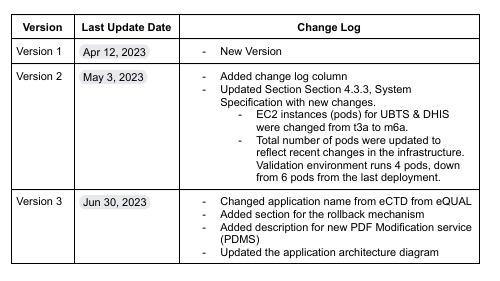

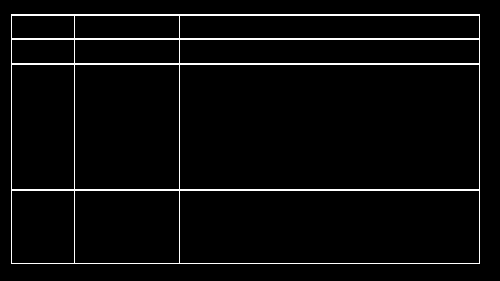

73 154 511 377


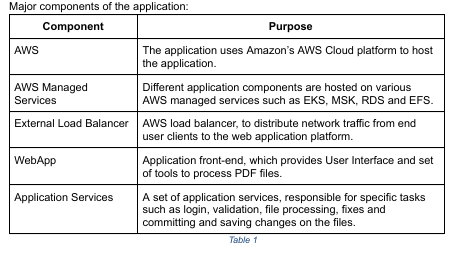

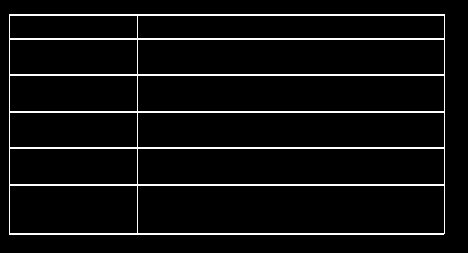

71 341 539 533


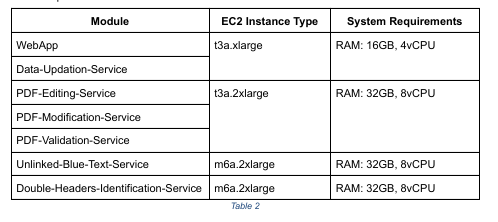

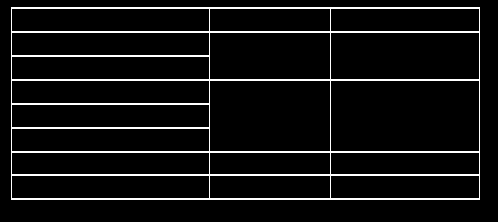

In [ ]:
tables = main_func("/content/eQUAL High-Level Technical Design Document.docx (1).pdf")

In [ ]:
[{'page_no': 0, 'bbox': [[61, 243, 561, 524]], 'data': [['  Version', '  Last Update Date', '  Change Log'], ['  Version 1', '  Apr 12, 2023', '  - New Version'], ['  Version 2', '  May 3, 2023', '  - Added change log column - Updated Section Section 4.3.3, System Specification with new changes. - EC2 instances (pods) for UBTS & DHIS were changed from t3a to m6a. - Total number of pods were updated to reflect recent changes in the infrastructure. Validation environment runs 4 pods, down from 6 pods from the last deployment.'], ['  Version 3', '  Jun 30, 2023', '  - Changed application name from eCTD from eQUAL - Added section for the rollback mechanism - Added description for new PDF Modification service (PDMS) - Updated the application architecture diagram']]}, {'page_no': 3, 'bbox': [[63, 144, 531, 397]], 'data': [[' ', '"Component"', ' ', ' ', ' ', ' ', ' ', ' ', '"Purpose"', ' ', ' ', ' ', ' '], ['"AWS"', ' ', ' ', ' ', ' ', '"The"', '"application"', '"to"', '"Amazon’s"', ' ', '"platform"', ' ', '"host"'], [' ', ' ', ' ', ' ', ' ', '"the"', '"application."', ' ', ' ', ' ', ' ', ' ', ' '], [' ', '"Managed"', ' ', ' ', ' ', '"Different"', ' ', '"application"', '"components"', '"on"', '"various"', ' ', ' '], ['"Services"', ' ', ' ', ' ', ' ', '"such"', '"as"', '"and"', '"services"', '"EKS,"', '"RDS"', ' ', '"EFS."'], ['"External"', ' ', '"Load"', ' ', '"Balancer"', ' ', '"load"', '"to"', '"distribute"', '"network"', '"from"', ' ', '"end"'], [' ', ' ', ' ', ' ', ' ', '"user"', '"clients"', '"application"', '"web"', '"platform."', ' ', ' ', ' '], ['"Application"', ' ', ' ', ' ', ' ', ' ', '"set"', '"front-end,"', '"which"', '"provides"', '"and"', ' ', ' '], [' ', ' ', ' ', ' ', ' ', '"of"', '"tools"', '"process"', '"files."', ' ', ' ', ' ', '"to"'], [' ', ' ', ' ', '"Services"', ' ', '"A"', '"of"', ' ', '"services,"', '"responsible"', '"specific"', ' ', '"tasks"'], [' ', ' ', ' ', ' ', ' ', ' ', ' ', '"login,"', '"file"', '"processing,"', '"fixes"', '"and"', ' '], [' ', ' ', ' ', ' ', ' ', '"committing"', ' ', ' ', '"changes"', '"the"', '"files."', ' ', '"and"'], [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '"Table 1"', ' ', ' ', ' ', ' ']]}, {'page_no': 4, 'bbox': [[61, 331, 559, 553]], 'data': [['  Module', '  EC2 Instance Type', '  System Requirements'], ['  WebApp', '  t3a.xlarge', '  RAM: 16GB, 4vCPU'], ['  Data-Updation-Service', ' ', ' '], ['  PDF-Editing-Service', '  t3a.2xlarge', '  RAM: 32GB, 8vCPU'], ['  PDF-Modification-Service', ' ', ' '], ['  PDF-Validation-Service', ' ', ' '], ['  Unlinked-Blue-Text-Service', '  m6a.2xlarge', '  RAM: 32GB, 8vCPU'], ['  Double-Headers-Identification-Service', '  m6a.2xlarge', '  RAM: 32GB, 8vCPU']]}]

In [ ]:
len(tables), tables[0].keys()

(3, dict_keys(['page_no', 'bbox', 'data']))

Some weights of the model checkpoint at TahaDouaji/detr-doc-table-detection were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


digital SCANNED {'digital': [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

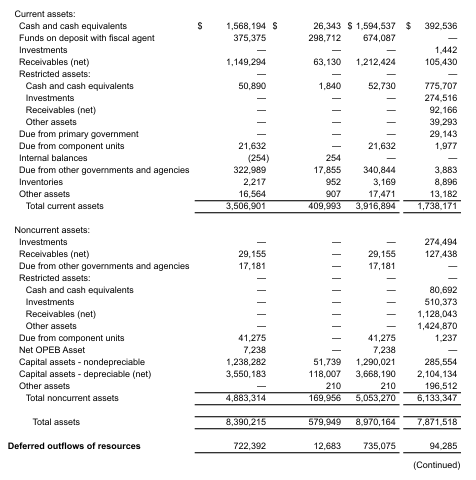

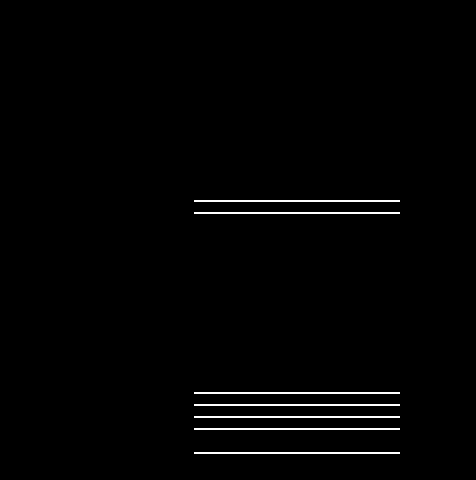

81 39 529 710


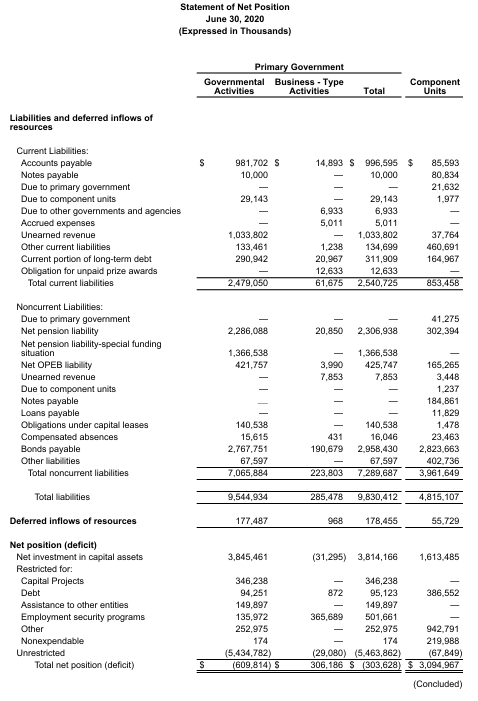

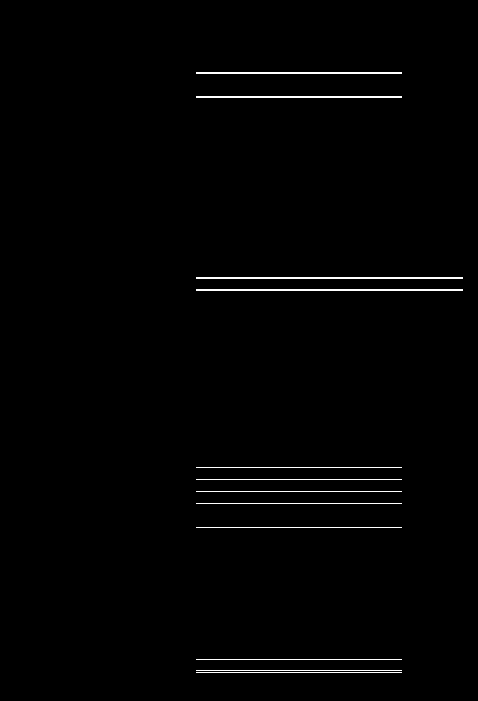

57 117 729 543


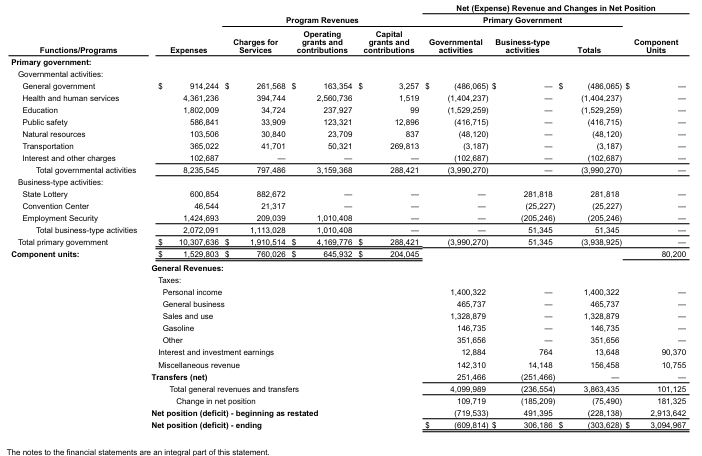

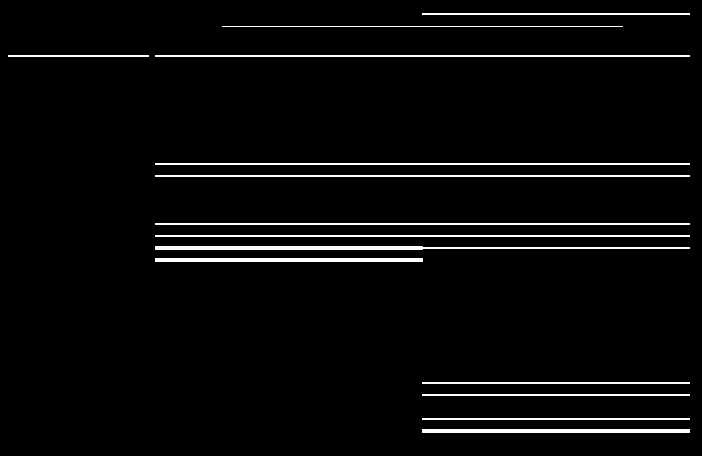

76 154 534 697


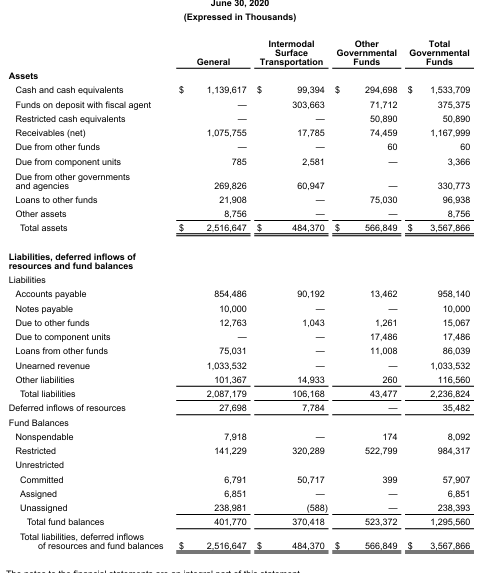

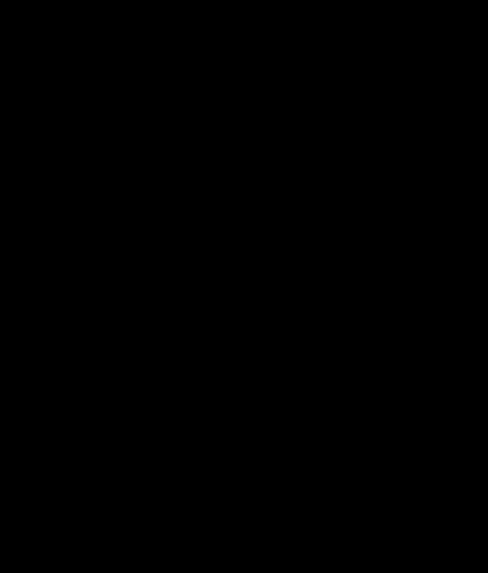

88 168 525 704


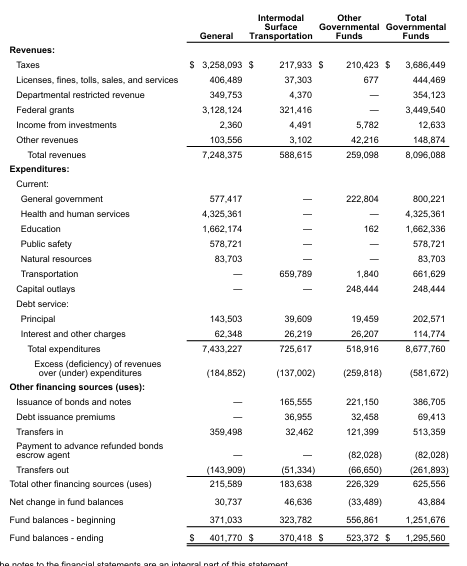

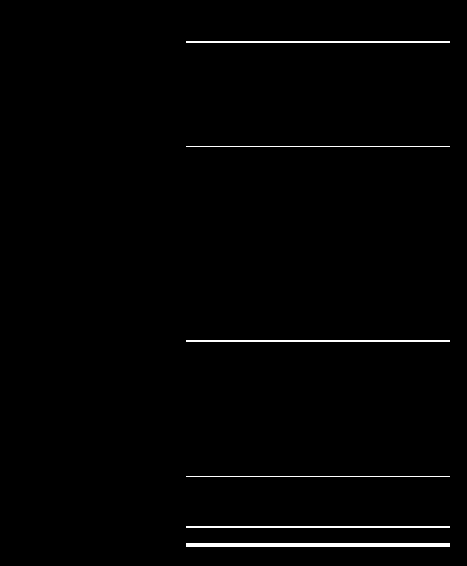

161 1077 1073 1470


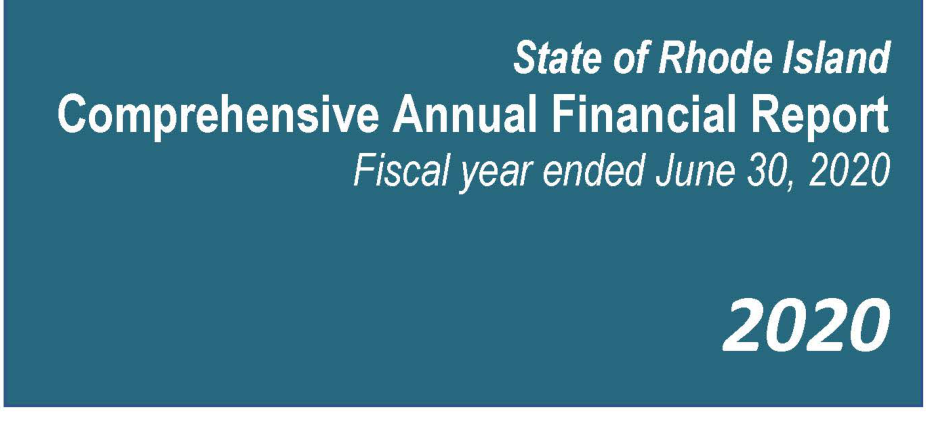

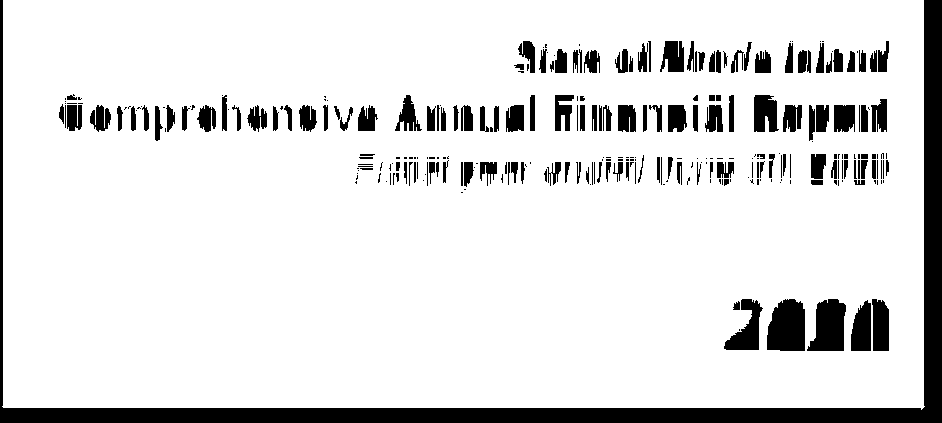

165 1076 1072 1471


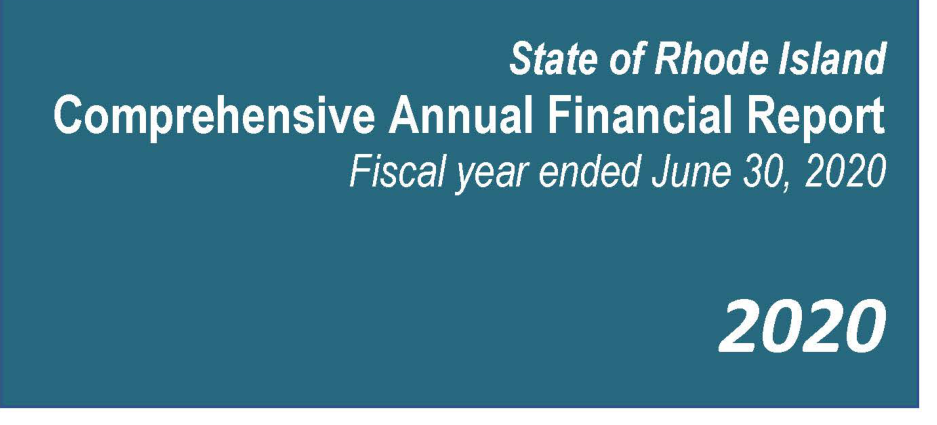

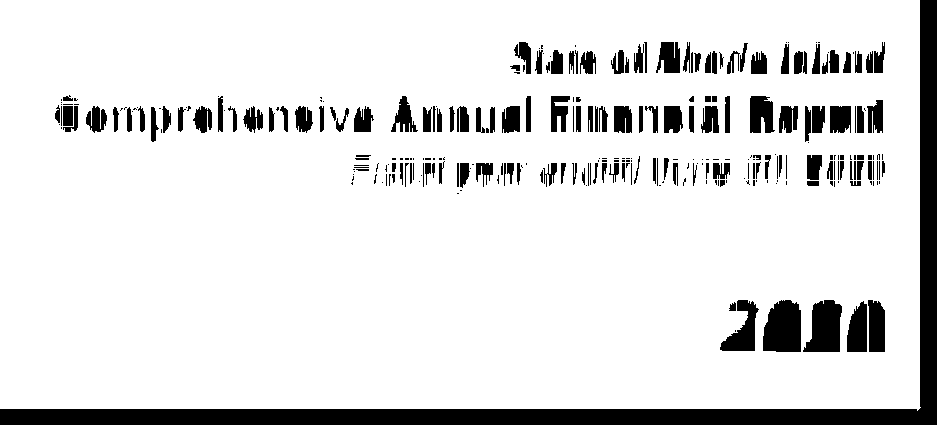

In [ ]:
tables = main_func("/content/CAFR 06-30-2020 (1).pdf")

In [ ]:
import json

data=json.dumps(tables)
with open("data.txt",'w') as f:
  f.write(data)

In [ ]:
import pandas as pd

df = pd.DataFrame(tables[0]["data"])
df.to_csv("oooooooooo.csv", index = False)

In [ ]:

class TableExtraction():

  def __init__(self, doc_path):

    self.doc_path = doc_path

    self.table_detector = DetectTable()
    self.document = fitz.open(self.doc_path)


  def execute(self):

    pages_dict = self.get_pdf_searchable_pages(self.doc_path)
    self.tables= {}

    print("digital SCANNED", pages_dict)
    self.extracted_table_list=[]
    # pages_dict['digital']=list(range(45,51))
    for page_no in pages_dict['digital']:

        page_no-=1
        zoom_x = 1.0
        zoom_y = 1.0
        page = self.document[page_no]
        mat = fitz.Matrix(zoom_x, zoom_y)
        pix = page.get_pixmap(matrix=mat)
        pix.save("page.png")
        table_list,_ = self.table_detector.extract_table_bbox("/content/page.png")
        # print(table_list)
        if len(table_list)>0:
          page_image=cv2.imread('page.png')
          for table_no,bbox in enumerate(table_list):
            cropped_image=self.extract_bounding_box(bbox,page_image)

            if self.is_bodered(cropped_image):
                extract_data = ExtractDataBordered(page_image, page_no,bbox,table_no,self.doc_path)
                data= extract_data.execute(page_no,table_no)
                if data["data"] != [[" "]]:
                  self.extracted_table_list.append(data)

            else :
                table_gen = GenerateTable(bbox,page_no,self.doc_path)
                data= table_gen.execute(page_no,table_no)
                if data["data"] != [[" "]]:
                  self.extracted_table_list.append(data)


    for page_no in pages_dict['scanned']:
        page_no-=1
        zoom_x = 2.0
        zoom_y = 2.0
        page = self.document[page_no]
        mat = fitz.Matrix(zoom_x, zoom_y)
        pix = page.get_pixmap(matrix=mat)
        pix.save("page.png")
        table_list,_ = self.table_detector.extract_table_bbox("/content/page.png")
        # print(table_list)
        if len(table_list)>0:
          page_image=cv2.imread('page.png')
          for table_no,bbox in enumerate(table_list):
            cropped_image=self.extract_bounding_box(bbox,page_image)

            if self.is_bodered(cropped_image):
                extract_data = ExtractDataBorderedScanned(page_image, page_no,bbox,table_no,self.doc_path)
                data= extract_data.execute(page_no,table_no)
                if data["data"] != [[" "]]:
                  self.extracted_table_list.append(data)

            else :
              lines_remover = TableLinesRemover(cropped_image)
              image_without_lines = lines_remover.execute()
              ocr_tool = OcrToTableTool(image_without_lines,cropped_image,page_no,table_no,bbox)
              data= ocr_tool.execute()
              if data["data"] != [[" "]]:
                self.extracted_table_list.append(data)




    return self.extracted_table_list

  def extract_bounding_box(self,bbox,image):
      x1, y1, x2, y2 = bbox
      height=abs(y2-y1)
      width=abs(x2-x1)
      extracted_image = image[y1:y1+height, x1:x1+width]
      # cv2_imshow(extracted_image)
      return extracted_image

  def get_pdf_searchable_pages(self,fname):
    # pip install pdfminer
    from pdfminer.pdfpage import PDFPage
    searchable_pages = []
    non_searchable_pages = []
    page_num = 0
    with open(fname, 'rb') as infile:

        for page in PDFPage.get_pages(infile):
            page_num += 1
            if 'Font' in page.resources.keys():
                searchable_pages.append(page_num)
            else:
                non_searchable_pages.append(page_num)
    if page_num > 0:
        # if len(searchable_pages) == 0:
        #     # print(f"Document '{fname}' has {page_num} page(s). "
        #     #       f"Complete document is non-searchable")
        #     return False
        # elif len(non_searchable_pages) == 0:
        #     # print(f"Document '{fname}' has {page_num} page(s). "
        #     #       f"Complete document is searchable")
        #     return True
        # else:
        #     # print(f"searchable_pages : {searchable_pages}")
        #     # print(f"non_searchable_pages : {non_searchable_pages}")
        #     return [searchable_pages, non_searchable_pages]
        return {'digital':searchable_pages,"scanned":non_searchable_pages}
    else:
        print(f"Not a valid document")

  def extract_table_digital_borderless(self,page_no,bbox_list):
    doc_path=self.doc_path

    for i,j in enumerate(bbox_list):
      table_gen = GenerateTable(j,page_no,doc_path)
      table = table_gen.execute(page_no,i)

  def is_bodered(self,image):

    cv2_imshow(image)
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresholded_image = cv2.threshold(grey, 250, 255, cv2.THRESH_BINARY)[1]
    inverted_image = cv2.bitwise_not(thresholded_image)

    hor = np.array([[1,1,1,1,1,1, 1]])
    vertical_lines_eroded_image = cv2.erode(inverted_image, hor, iterations=15)
    vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=15)
    # cv2_imshow(vertical_lines_eroded_image)
    r_contours, hierarchy = cv2.findContours(vertical_lines_eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ver = np.array([[1],
                [1],
                [1],
                [1],
                [1],
                [1],
                [1]])
    horizontal_lines_eroded_image = cv2.erode(inverted_image, ver, iterations=15)
    horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=15)
    c_contours, hierarchy = cv2.findContours(horizontal_lines_eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # cv2_imshow(horizontal_lines_eroded_image)

    combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)
    cv2_imshow(combined_image)

    rows, columns = self.get_rows_and_columns(r_contours, c_contours)
    # print(rows, columns)
    # if len(rows) > 2 and len(columns) > 2:
    if (len(rows) =< 2 and len(columns) >2) or (len(rows) > 2 and len(columns) <= 2):
      if self.intersects(rows, columns):
        return True
    return False

  def intersects(self,rows, columns):
    i = 0
    # print(len(rows), len(columns))
    for xr0, yr0, xr1, yr1 in rows:
      for xc0, yc0, xc1, yc1 in columns:
        # print(xr0, yr0, xr1, yr1, xc0, yc0, xc1, yc1)
        if xr0 <= xc0 and yr0 >= yc0 and xr1 >= xc1 and yr1 <= yc1:
          i+=1
    cal_i = (len(rows) * len(columns))*2/3
    # print(i, cal_i)
    return True if i >= cal_i else False

  def get_rows_and_columns(self,r_c, c_c):
    row_range = []
    for line in r_c:
      sorted_data = sorted(line, key=lambda x: x[0][0])
      row_range.append([sorted_data[0][0][0], sorted_data[0][0][1], sorted_data[-1][0][0], sorted_data[-1][0][1]])
    row_range.sort()

    column_range = []
    for line in c_c:
      sorted_data = sorted(line, key=lambda x: x[0][1])
      column_range.append([sorted_data[0][0][0], sorted_data[0][0][1], sorted_data[-1][0][0], sorted_data[-1][0][1]])
    column_range.sort()

    return row_range, column_range

  def read_pdf(self,is_scanned=False):



    zoom_x = 1.0 if not is_scanned else 2.0
    zoom_y = 1.0 if not is_scanned else 2.0

    if is_scanned == False or is_scanned == True :
      no_of_pages = len(self.document)
      for page_no in range(no_of_pages):
        page = self.document[page_no]
        mat = fitz.Matrix(zoom_x, zoom_y)
        pix = page.get_pixmap(matrix=mat)
        pix.save("page.png")

        table_list = self.table_detector.execute("/content/page.png","tables_cropped",page_no)
        os.remove("/content/page.png")
        if len(table_list)>=1:
          self.tables[page_no] = table_list


    elif isinstance(is_scanned, (list)):
      digital_list = is_scanned[0]
      scanned_list = is_scanned[1]
      for page_no in digital_list:
        zoom_x = 1.0
        zoom_y = 1.0
        page = self.document[page_no]
        mat = fitz.Matrix(zoom_x, zoom_y)
        pix = page.get_pixmap(matrix=mat)
        pix.save("page.png")
        table_list = self.table_detector.execute("/content/page.png","tables_cropped_digital",page_no)
        if len(table_list)>=1:
          self.tables[page_no] = table_list
      for page_no in scanned_list:
        zoom_x = 2.0
        zoom_y = 2.0
        page = self.document[page_no]
        mat = fitz.Matrix(zoom_x, zoom_y)
        pix = page.get_pixmap(matrix=mat)
        pix.save("page.png")
        table_list = self.table_detector.execute("/content/page.png","tables_cropped_scanned",page_no)
        if len(table_list)>=1:
          self.tables[page_no] = table_list

    return self.tables
